In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://mirrors.tuna.tsinghua.edu.cn/anaconda/miniconda/Miniconda3-4.7.12.1-Linux-x86_64.sh
!bash Miniconda3-4.7.12.1-Linux-x86_64.sh -bfp /usr/local

--2023-08-12 03:46:07--  https://mirrors.tuna.tsinghua.edu.cn/anaconda/miniconda/Miniconda3-4.7.12.1-Linux-x86_64.sh
Resolving mirrors.tuna.tsinghua.edu.cn (mirrors.tuna.tsinghua.edu.cn)... 101.6.15.130, 2402:f000:1:400::2
Connecting to mirrors.tuna.tsinghua.edu.cn (mirrors.tuna.tsinghua.edu.cn)|101.6.15.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/octet-stream]
Saving to: ‘Miniconda3-4.7.12.1-Linux-x86_64.sh’

Miniconda3-4.7.12.1 100%[===================>]  68.46M  11.4MB/s    in 7.5s    

2023-08-12 03:46:16 (9.14 MB/s) - ‘Miniconda3-4.7.12.1-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37

In [ ]:
#!wget http://ciscobinary.openh264.org/libopenh264-2.3.1-linux64.7.so.bz2

In [ ]:
import sys
sys.path

In [ ]:
sys.path.remove()

In [3]:
import os
os.chdir("/content/drive/MyDrive/InSTvideo")

In [4]:
!conda env update -f environment.yaml

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c defaults conda



wheel-0.38.4         | 64 KB     | : 100% 1.0/1 [00:00<00:00,  5.70it/s]
markupsafe-2.1.1     | 34 KB     | : 100%

In [ ]:
!conda env list
!which python

In [ ]:
!which python
!conda env list
import os
os.environ['PATH'] = '/usr/local/envs/ldm/bin:' + os.environ['PATH']
!which python

In [5]:
import sys

sys.path.append('/usr/local/envs/ldm/lib/python3.10/site-packages')
sys.path.append('/content/drive/MyDrive/InSTvideo/src/taming-transformers')
sys.path.append('/content/drive/MyDrive/InSTvideo/src/clip')

In [6]:
"""make variations of input image"""

import argparse, os, sys, glob
import PIL
import torch
import torch.nn as nn
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
import time
from pytorch_lightning import seed_everything

sys.path.append(os.path.dirname(sys.path[0]))
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.to(device)
    model.eval()
    return model


def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((512, 512), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

In [ ]:
config="configs/stable-diffusion/v1-inference.yaml"
ckpt="models/sd/sd-v1-4.ckpt"
config = OmegaConf.load(f"{config}")
model = load_model_from_config(config, f"{ckpt}")
sampler = DDIMSampler(model)

In [ ]:
def main(prompt = '', content_dir = '', style_dir='',ddim_steps = 50,strength = 0.5, model = None, seed=42):
    ddim_eta=0.0
    n_iter=1
    C=4
    f=8
    n_samples=1
    n_rows=0
    scale=10.0

    precision="autocast"
    outdir="outputs/img2img-samples"
    seed_everything(seed)


    os.makedirs(outdir, exist_ok=True)
    outpath = outdir

    batch_size = n_samples
    n_rows = n_rows if n_rows > 0 else batch_size
    data = [batch_size * [prompt]]


    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(outpath)) + 10

    style_image = load_img(style_dir).to(device)
    style_image = repeat(style_image, '1 ... -> b ...', b=batch_size)
    style_latent = model.get_first_stage_encoding(model.encode_first_stage(style_image))  # move to latent space

    content_name =  content_dir.split('/')[-1].split('.')[0]
    content_image = load_img(content_dir).to(device)
    content_image = repeat(content_image, '1 ... -> b ...', b=batch_size)
    content_latent = model.get_first_stage_encoding(model.encode_first_stage(content_image))  # move to latent space

    init_latent = content_latent

    sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

    assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
    t_enc = int(strength * ddim_steps)
    print(f"target t_enc is {t_enc} steps")

    precision_scope = autocast if precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                for n in trange(n_iter, desc="Sampling"):
                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""], style_image)
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)

                        c= model.get_learned_conditioning(prompts, style_image)

                        # img2img

                        # stochastic encode
                        # z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))

                        # stochastic inversion
                        t_enc = int(strength * 1000)
                        x_noisy = model.q_sample(x_start=init_latent, t=torch.tensor([t_enc]*batch_size).to(device))
                        model_output = model.apply_model(x_noisy, torch.tensor([t_enc]*batch_size).to(device), c)
                        z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device),\
                                                          noise = model_output, use_original_steps = True)

                        t_enc = int(strength * ddim_steps)
                        samples = sampler.decode(z_enc, c, t_enc,
                                                unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=uc,)
                        print(z_enc.shape, uc.shape, t_enc)

                        # txt2img
            #             noise  =torch.randn_like(content_latent)
            #             samples, intermediates =sampler.sample(ddim_steps,1,(4,512,512),c,verbose=False, eta=1.,x_T = noise,
            #    unconditional_guidance_scale=scale,
            #    unconditional_conditioning=uc,)

                        x_samples = model.decode_first_stage(samples)

                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            base_count += 1
                        all_samples.append(x_samples)

                # additionally, save as grid
                grid = torch.stack(all_samples, 0)
                grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                grid = make_grid(grid, nrow=n_rows)

                # to image
                grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                output = Image.fromarray(grid.astype(np.uint8))
                output.save(os.path.join(outpath, content_name+'-'+prompt+f'-{grid_count:04}.png'))
                # Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                grid_count += 1

                toc = time.time()
    return output

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# model.cpu()
model.embedding_manager.load('./embeddings/woman_embeddings.pt')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


find keys: dict_keys(['string_to_token', 'attention'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (427, 413) from ./Images/woman/people28.jpeg
target t_enc is 350 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 350 timesteps




Decoding image:   0%|          | 0/350 [00:00<?, ?it/s]

Decoding image:   0%|          | 1/350 [00:00<01:51,  3.12it/s]

Decoding image:   1%|          | 2/350 [00:00<01:07,  5.19it/s]

Decoding image:   1%|          | 3/350 [00:00<00:52,  6.56it/s]

Decoding image:   1%|          | 4/350 [00:00<00:45,  7.55it/s]

Decoding image:   1%|▏         | 5/350 [00:00<00:42,  8.20it/s]

Decoding image:   2%|▏         | 6/350 [00:00<00:39,  8.66it/s]

Decoding image:   2%|▏         | 7/350 [00:00<00:38,  9.00it/s]

Decoding image:   2%|▏         | 8/350 [00:01<00:37,  9.21it/s]

Decoding image:   3%|▎         | 9/350 [00:01<00:36,  9.40it/s]

Decoding image:   3%|▎         | 10/350 [00:01<00:35,  9.50it/s]

Decoding image:   3%|▎         | 11/350 [00:01<00:35,  9.54it/s]

Decoding image:   3%|▎         | 12/350 [00:01<00:35,  9.59it/s]

Decoding image:   4%|▎         | 13/350 [00:01<00:35,  9.62it/s]

Decoding image:   4%|▍         | 14/350 [00:01<00:34,  9.65it/s]

Decoding image:   4%|▍    

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 350


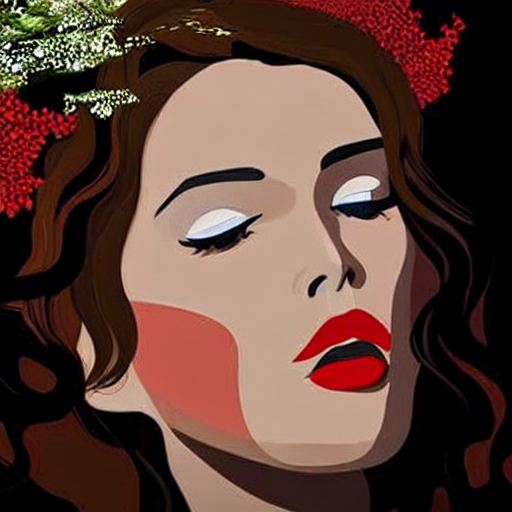

In [ ]:
main(prompt = '*', \
     content_dir = './Images/woman/people28.jpeg', \
     style_dir = './Images/woman/woman.png', \
     ddim_steps = 500, \
     strength = 0.7, \
     seed=42, \
     model = model)

In [ ]:
#!pip install scikit-video

In [ ]:
import argparse
import os
import torch
import torch.nn as nn
from PIL import Image
from os.path import basename
from os.path import splitext
from torchvision import transforms
from torchvision.utils import save_image
from function import calc_mean_std, normal, coral
import net as net
import numpy as np
import cv2
import yaml


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def load_video(content_path,style_path, outfile):
    video = cv2.VideoCapture(content_path)

    rate = video.get(5)
    width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)  # 获得帧宽和帧高
    fps = int(rate)

    video_name = outfile + '/{:s}_stylized_{:s}{:s}'.format(
        splitext(basename(content_path))[0], splitext(basename(style_path))[0], '.avi')

    videoWriter = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), fps,(512,512))
    return video,videoWriter

# def save_frame(output, videoWriter):
#     output = output * 255 + 0.5
#     output = torch.uint8(torch.clamp(output, 0, 255).permute(1, 2, 0)).numpy()
#     output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
#     videoWriter.write(output)  # 写入帧图

def save_frame(output, videoWriter):
  output = torch.from_numpy(np.array(output))
  output = output * 255 + 0.5
  output = (torch.clamp(output, 0, 255).permute(1, 2, 0)).numpy().astype(np.uint8)
  output = np.transpose(output, (2, 0, 1))
     #output_array = output.numpy()  # 转换为 NumPy 数组
  output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)

  videoWriter.write(output)

# def save_frame(output,videoWriter):
#   img=cv2.imread(output)
#   videoWriter.write(img)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def process_video(content_path, style_path, outfile):
    j = 0
    video, videoWriter = load_video(content_path, style_path, outfile)
    while (video.isOpened()):
        j = j + 1
        ret, frame = video.read()
        if not ret:
            break

        if j % 1 == False:
            # 对每一帧进行风格化。
            #style = Image.open(style_path)
            content = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            content.save(os.path.join('tmp.png'))
            output = main(prompt = '*',content_dir = 'tmp.png', style_dir = './Images/woman/woman.png',ddim_steps = 50, \
            strength = 0.7,seed=42, model = model)
            # 对风格化后的结果进行额外处理，以存储到视频中
            save_frame(output, videoWriter)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
video, videoWriter = load_video(content_path, style_path, outfile)
ret,frame = video.read()

content = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
content.save('tmp'+'.png')

# output = main(prompt = '*',content_dir = './tmp.png', style_dir = './Images/woman/woman.png',ddim_steps = 50, \
#             strength = 0.7,seed=42, model = model)

# output = torch.from_numpy(np.array(output))
# output = output * 255 + 0.5

# output = (torch.clamp(output, 0, 255).permute(1, 2, 0)).numpy().astype(np.uint8)
# output = np.transpose(output, (2, 0, 1))
#      #output_array = output.numpy()  # 转换为 NumPy 数组
# output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)

# videoWriter.write(output)

In [ ]:
video, videoWriter = load_video(content_path, style_path, outfile)
video,videoWriter

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(< cv2.VideoCapture 0x7ec5df57b570>, < cv2.VideoWriter 0x7ec5df57b370>)

In [ ]:
def test(content_paths, style_paths):
        # 视频风格化
        for style_path in style_paths:
                process_video(content_path, style_path, outfile)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
content_path = './room.mp4'
style_path = ''
outfile = 'outputs'
process_video(content_path, style_path, outfile)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.16it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.12it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.07it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.08it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.03it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.00it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.00it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.04it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.04it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.04it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.04it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.04it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.03it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.11it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.13it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.11it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.07it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.05it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.08it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.09it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.08it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.07it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.08it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.08it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.08it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.09it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.16it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.12it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.01it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.01it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.03it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.01it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.01it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.01it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.99it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.95it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.92it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.90it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01,  9.83it/s]

Decoding image:  66%|██████▌   | 23/35 [00:02<00:01,  9.82it/s]

Decoding image:  69%|██████▊   | 24/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.18it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.02it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.04it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02,  9.98it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.96it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.89it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.86it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.86it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.76it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.77it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.80it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.78it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.72it/s]

Decoding image:  57%|█████▋    | 20/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.01it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.99it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.91it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.86it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.83it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.83it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.83it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.81it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.72it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.75it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.77it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.78it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.26it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.19it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.14it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.11it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.05it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.07it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.08it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.11it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.10it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.10it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.07it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.09it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.09it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.09it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03, 10.00it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.90it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.86it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.85it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.86it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.88it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.86it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.85it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.86it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.82it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.77it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.78it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.81it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.85it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.99it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.83it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.82it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.82it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.74it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.74it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.74it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.76it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.77it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.82it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.82it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.81it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.78it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.78it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.08it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.04it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.99it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.94it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.88it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.81it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.78it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.76it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.78it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.79it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.80it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.80it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.77it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.24it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.75it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.77it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.75it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.76it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.78it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.79it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.79it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.77it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.76it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.78it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.75it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.80it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.82it/s]

Decoding image:  49%|████▊     | 17/35 

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.14it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.05it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.03it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.00it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.00it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.99it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.93it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.89it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.87it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.84it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.81it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.78it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.77it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.76it/s]

Decoding image:  60%|██████    | 21/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.91it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.79it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.77it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.77it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.85it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.88it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.01it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.99it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.89it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.87it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.84it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.83it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.83it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.82it/s]

Decoding image:  46%|████▌     | 16/35 [

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.97it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.91it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.83it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.83it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.82it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.78it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.78it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.76it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.75it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.75it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.74it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.77it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.72it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.74it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03, 10.00it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.71it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.72it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.74it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.74it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.75it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.75it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.76it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.74it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.78it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.67it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.68it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.72it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.73it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.89it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.72it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.70it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.71it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.74it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.76it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.69it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.68it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.69it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.67it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.68it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.69it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.73it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.74it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.98it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.93it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.89it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.85it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.84it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.79it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.76it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.75it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.72it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.73it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.72it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.71it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.76it/s]

Decoding image:  49%|████▊     | 17/35 

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.20it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.07it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.06it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.06it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.07it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.07it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.03it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.02it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.02it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.04it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.05it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.06it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.05it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.07it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.25it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.94it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.82it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.77it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.74it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.77it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.77it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.82it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.79it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.78it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.84it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.82it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.85it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.77it/s]

Decoding image:  49%|████▊     | 17/35 

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.87it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.78it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.80it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.78it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.79it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.76it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.73it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.71it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.71it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.75it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.61it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.68it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.70it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.74it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.15it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.06it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.03it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.03it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.02it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.02it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.03it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.03it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.04it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.01it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.03it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.03it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.03it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.25it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.17it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.09it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.08it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.05it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.08it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.08it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.07it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.08it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.06it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.08it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.05it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.06it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.08it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.10it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.08it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.07it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.08it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.07it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.06it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.09it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.08it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.08it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.06it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.08it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.20it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.11it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.09it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.07it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.08it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.06it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.05it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.05it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.03it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.02it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.03it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.02it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.02it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.01it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.22it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.10it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.01it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.99it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.95it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.90it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.87it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.84it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.81it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.76it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.72it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.76it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.76it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.77it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.22it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.11it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.06it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.05it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.02it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.90it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.88it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.84it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.82it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.79it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.76it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.77it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.77it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.77it/s]

Decoding image:  60%|██████    | 21/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.12it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.10it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.07it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.04it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.04it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.03it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.02it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.04it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.03it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.04it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.03it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.04it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.02it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.98it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.87it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.85it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.85it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.80it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.81it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.80it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.81it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.83it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.85it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.88it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.85it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.84it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.80it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.09it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.04it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.04it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.01it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.02it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.03it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.04it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.02it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.02it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01,  9.97it/s]

Decoding image:  66%|██████▌   | 23/35 [00:02<00:01,  9.94it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01,  9.91it/s]

Decoding image:  71%|███████▏  | 25/35 [00:02<00:01,  9.85it/s]

Decoding image:  74%|███████▍  | 26/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  8.81it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.37it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.46it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.47it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.55it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:03,  9.57it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.59it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.56it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.59it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.61it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.64it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.62it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.60it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.63it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.23it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.07it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.01it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.82it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.80it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.77it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.72it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.50it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.59it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.63it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.66it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.70it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.73it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.73it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.20it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.10it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.05it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.04it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.04it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.03it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.06it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.03it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.03it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.04it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.05it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.04it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.98it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.87it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.85it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.86it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.89it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.83it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.83it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.82it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.80it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.78it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.79it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.76it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.81it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.65it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.12it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.06it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.06it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.04it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.03it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.03it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.03it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.01it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.01it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.02it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.03it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.02it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.20it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.99it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.90it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.87it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.84it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.78it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.76it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.76it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.75it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.74it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.68it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.69it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.69it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.69it/s]

Decoding image:  49%|████▊     | 17/35 

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.09it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.05it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.04it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.01it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.00it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.02it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.02it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.01it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.01it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.00it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.97it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01,  9.93it/s]

Decoding image:  66%|██████▌   | 23/35 [00:02<00:01,  9.88it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01,  9.81it/s]

Decoding image:  71%|███████▏  | 25/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.13it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.08it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.04it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.05it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.05it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.06it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.06it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.04it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.05it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.04it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.03it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.02it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.02it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.23it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.02it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.04it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.05it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.06it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.06it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.06it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.05it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.04it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.05it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.07it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.06it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03, 10.00it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.89it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.80it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.84it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.89it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.87it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.84it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.78it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.73it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.76it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.75it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.78it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.79it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.78it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.11it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.04it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.00it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.93it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.86it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.78it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.67it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.68it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.66it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.56it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.57it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.60it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.65it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.67it/s]

Decoding image:  51%|█████▏    | 18/35

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.22it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.09it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.98it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.92it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.89it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.84it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.81it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.77it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.74it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.70it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.69it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.68it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.70it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.70it/s]

Decoding image:  51%|█████▏    | 18/35

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.99it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.91it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.86it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.80it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.85it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.84it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.81it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.79it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.76it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.78it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.79it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.82it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.82it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.79it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.27it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.15it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.06it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.07it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.05it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.05it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.06it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.06it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.98it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.92it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.86it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.71it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01,  9.76it/s]

Decoding image:  66%|██████▌   | 23/35 [00:02<00:01,  9.77it/s]

Decoding image:  69%|██████▊   | 24/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.22it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.09it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.03it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.01it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02,  9.99it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.93it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.83it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.78it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.78it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.77it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.75it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.75it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.72it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.69it/s]

Decoding image:  57%|█████▋    | 20/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.23it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.14it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.12it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.11it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.06it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.04it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.05it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.05it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.05it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.05it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.06it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.06it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.06it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.10it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.02it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.98it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.93it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.86it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.85it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.59it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.57it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.64it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.68it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.68it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.73it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.75it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.21it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.10it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.09it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.12it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.09it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.06it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.06it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.06it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.08it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.09it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.11it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.10it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.09it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.08it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.28it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.12it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.08it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.10it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.08it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.06it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.08it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.08it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.07it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.06it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.01it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.01it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.02it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.01it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.23it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.14it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.12it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.08it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.08it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.08it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.09it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.09it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.08it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.06it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.07it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.03it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.05it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.99it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.77it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.78it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.79it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.83it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.80it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.81it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.79it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.81it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.77it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.73it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.74it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.75it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.76it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.19it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.13it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.03it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.02it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.01it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.01it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.00it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.03it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.05it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.04it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.04it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.05it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.04it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.11it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.10it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.07it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.06it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.05it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.05it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.05it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.02it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.00it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.01it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.04it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.03it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.05it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.12it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.08it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.03it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.04it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.04it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.07it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.04it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.05it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.03it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.04it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.03it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.04it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.25it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.17it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.09it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.11it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.10it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.07it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.03it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.00it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.93it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.89it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.84it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.80it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.75it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01,  9.79it/s]

Decoding image:  66%|██████▌   | 23/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.19it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.12it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.09it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.09it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.06it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.04it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.03it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.99it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.97it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.94it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.92it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.90it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.89it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01,  9.86it/s]

Decoding image:  66%|██████▌   | 23/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.13it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.04it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.01it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.96it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.91it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.89it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.81it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.77it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.75it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.77it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.78it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.76it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.66it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.65it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.91it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.81it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.78it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.78it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.75it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.73it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.75it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.80it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.84it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.83it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.81it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.76it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.76it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.78it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.98it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.92it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.88it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.83it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.80it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.80it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.79it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.77it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.80it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.84it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.85it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.83it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.80it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.82it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.25it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.14it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.09it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.08it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.06it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.05it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.02it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.03it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.05it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.06it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.04it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.02it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.01it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.94it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.87it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.84it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.82it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.80it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.80it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.79it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.79it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.79it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.73it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.76it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.75it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.73it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.60it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.26it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.16it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.08it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.08it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.06it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.04it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.03it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.04it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.04it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.05it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.06it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.04it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.02it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00,  9.92it/s]

Decoding image:  83%|████████▎ | 29/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.85it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.72it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.75it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.76it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.76it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.76it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.76it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.77it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.67it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.69it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.70it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.72it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.71it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.68it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.15it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.08it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.03it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.02it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.00it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.95it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.92it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.87it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.88it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.84it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.81it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.78it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.76it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.77it/s]

Decoding image:  57%|█████▋    | 20/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.14it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.03it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.05it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.02it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.02it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.02it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.04it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.03it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.03it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.04it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.01it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.02it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.05it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.15it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.05it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.75it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.71it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.71it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.72it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.73it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.47it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.54it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.59it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.66it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.61it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.60it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.67it/s]

Decoding image:  51%|█████▏    | 18/35

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.20it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.02it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.97it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.87it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.85it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.84it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.83it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.81it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.79it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.80it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.80it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.78it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.78it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.78it/s]

Decoding image:  51%|█████▏    | 18/35

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.15it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.11it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.05it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.98it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.95it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.92it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.87it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.83it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.85it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.85it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.82it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.82it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.83it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.81it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.86it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.86it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.85it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.84it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.81it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.81it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.77it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.77it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.81it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.83it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.80it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.83it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.83it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.81it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.14it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.09it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.06it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.04it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.05it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.02it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.04it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.02it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.01it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01,  9.99it/s]

Decoding image:  71%|███████▏  | 25/35 [00:02<00:01,  9.96it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00,  9.92it/s]

Decoding image:  77%|███████▋  | 27/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03, 10.00it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.83it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.80it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.77it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.78it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.79it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.72it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.72it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.76it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.75it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.75it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.73it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.75it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.74it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.67it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.73it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.73it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.73it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.71it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.70it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.72it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.72it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.73it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.68it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.70it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.69it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.69it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.66it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.90it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.82it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.75it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.75it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.69it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.70it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.69it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.67it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.69it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.71it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.68it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.68it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.68it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.66it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.13it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.09it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.05it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.98it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.96it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.91it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.88it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.86it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.84it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.83it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.84it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.82it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.83it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.83it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.21it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.14it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.10it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.10it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.07it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.90it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.88it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.80it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.66it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.64it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.68it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.67it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.68it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.69it/s]

Decoding image:  60%|██████    | 21/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.12it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.05it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.02it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.01it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02,  9.99it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.95it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.88it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.87it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.81it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.81it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.80it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.78it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.76it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.72it/s]

Decoding image:  57%|█████▋    | 20/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.19it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.00it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.03it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.03it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.01it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.01it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.99it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.94it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.89it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.83it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.82it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.80it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.80it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.77it/s]

Decoding image:  63%|██████▎   | 22/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.15it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.05it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.04it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.03it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.02it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.00it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.92it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.87it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.81it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.78it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.77it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.75it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.75it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.68it/s]

Decoding image:  60%|██████    | 21/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.94it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.84it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.79it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.75it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.72it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.70it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.67it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.67it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.66it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.64it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.66it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.66it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.69it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.67it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.10it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.05it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.01it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.03it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.02it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.00it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.98it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.93it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.87it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.83it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.81it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.82it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.80it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.78it/s]

Decoding image:  63%|██████▎   | 22/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.18it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.09it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.02it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.02it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.01it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.99it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.94it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.91it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.88it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.83it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.81it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.81it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.80it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.79it/s]

Decoding image:  60%|██████    | 21/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.16it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.01it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.90it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.84it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.53it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.52it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.53it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.52it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.55it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.53it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.47it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.52it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.53it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.56it/s]

Decoding image:  51%|█████▏    | 18/35

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.10it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.09it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.08it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.05it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.02it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.01it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.98it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.96it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.92it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.87it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.86it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.71it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01,  9.74it/s]

Decoding image:  66%|██████▌   | 23/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.14it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.09it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.01it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.97it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.90it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.85it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.81it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.79it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.74it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.71it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.67it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.70it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.74it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.75it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.20it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.07it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.05it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.05it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.01it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.03it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.03it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.04it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.04it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.03it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01,  9.94it/s]

Decoding image:  66%|██████▌   | 23/35 [00:02<00:01,  9.90it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01,  9.87it/s]

Decoding image:  71%|███████▏  | 25/35 [00:02<00:01,  9.84it/s]

Decoding image:  74%|███████▍  | 26/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.05it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.06it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.02it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.02it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.03it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.00it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.02it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.04it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.04it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.05it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.01it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.03it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.16it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.07it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.96it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.92it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.86it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.86it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.84it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.84it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.76it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.79it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.78it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.76it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.77it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.77it/s]

Decoding image:  51%|█████▏    | 18/35

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.98it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.89it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.86it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.88it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.88it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.88it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.87it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.87it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.88it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.85it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.83it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.83it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.84it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.80it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.21it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.13it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.04it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.07it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.07it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.05it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.06it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.07it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.08it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.06it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.06it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.06it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.02it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.02it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.16it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.13it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.12it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.09it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.10it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.08it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.07it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.05it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.06it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.06it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.05it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.01it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.01it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.00it/s]

Decoding image:  83%|████████▎ | 29/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.81it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.37it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.49it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.60it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.63it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.70it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.69it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.70it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.70it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.71it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.72it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.71it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.47it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.56it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.99it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.78it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.74it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.70it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.76it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.75it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.76it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.80it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.65it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.45it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.56it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.63it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.65it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.68it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.19it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.08it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.07it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.06it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.06it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.04it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.03it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.03it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.03it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.04it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.03it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.02it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.03it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.06it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.99it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.53it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.60it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.65it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.68it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.69it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.74it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.68it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.69it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.72it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.74it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.72it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.71it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.63it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.15it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.07it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.05it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.04it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.02it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.00it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.98it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.59it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.60it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.57it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.45it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.53it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.53it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.55it/s]

Decoding image:  63%|██████▎   | 22/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.13it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.11it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.01it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.96it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.70it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.64it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.65it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.63it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.60it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.66it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.68it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.70it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.68it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.69it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.15it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.07it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.00it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.95it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.87it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.81it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.65it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.66it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.62it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.49it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.54it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.55it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.62it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.61it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.21it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.10it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.06it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.03it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.02it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.03it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.05it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.01it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.01it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.03it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.04it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.03it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.03it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.20it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.09it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.10it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.09it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.10it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.08it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.07it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.05it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.06it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.05it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.02it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.01it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.03it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.03it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.12it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.09it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.05it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.05it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.08it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.07it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.05it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.04it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.02it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.02it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.00it/s]

Decoding image:  71%|███████▏  | 25/35 [00:02<00:01,  9.97it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00,  9.88it/s]

Decoding image:  77%|███████▋  | 27/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.16it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.96it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.89it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.84it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.82it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.81it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.82it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.76it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.79it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.77it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.79it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.75it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.70it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.74it/s]

Decoding image:  49%|████▊     | 17/35 

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.14it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.08it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.88it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.85it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.86it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.81it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.79it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.68it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.70it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.76it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.74it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.72it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.76it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.81it/s]

Decoding image:  51%|█████▏    | 18/35

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.93it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.79it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.80it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.78it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.65it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:03,  9.66it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.72it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.71it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.73it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.74it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.74it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.75it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.76it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.79it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.20it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.08it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.01it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.00it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.94it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.86it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.84it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.81it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.79it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.78it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.75it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.78it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.78it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.80it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.18it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.12it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.08it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.08it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.05it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.05it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.05it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.02it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.03it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.03it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.02it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.02it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.04it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.14it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.05it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.00it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.97it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.93it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.90it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.87it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.83it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.78it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.75it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.75it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.73it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.78it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.79it/s]

Decoding image:  54%|█████▍    | 19/3

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   3%|▎         | 1/35 [00:00<00:03,  9.99it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.85it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.78it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.71it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.65it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.67it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.65it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.55it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.30it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.42it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.50it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.53it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.55it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.53it/s]

Decoding image:  43%|████▎     | 15/35 [0

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.11it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.92it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.59it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:03,  9.63it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.69it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.70it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.74it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.77it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.81it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.80it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.84it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.82it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.82it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.81it/s]

Decoding image:  49%|████▊     | 17/35 

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.21it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.12it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.06it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.04it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.04it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.05it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.04it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.05it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01, 10.05it/s]

Decoding image:  57%|█████▋    | 20/35 [00:01<00:01, 10.08it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01, 10.08it/s]

Decoding image:  69%|██████▊   | 24/35 [00:02<00:01, 10.09it/s]

Decoding image:  74%|███████▍  | 26/35 [00:02<00:00, 10.05it/s]

Decoding image:  80%|████████  | 28/35 [00:02<00:00, 10.06it/s]

Decoding image:  86%|████████▌ | 30/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.06it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.05it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.06it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.03it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.02it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.99it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.94it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.89it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.82it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.83it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.81it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.80it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.78it/s]

Decoding image:  63%|██████▎   | 22/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03,  9.97it/s]

Decoding image:   9%|▊         | 3/35 [00:00<00:03,  9.92it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03,  9.87it/s]

Decoding image:  14%|█▍        | 5/35 [00:00<00:03,  9.81it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02,  9.78it/s]

Decoding image:  20%|██        | 7/35 [00:00<00:02,  9.78it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02,  9.83it/s]

Decoding image:  26%|██▌       | 9/35 [00:00<00:02,  9.82it/s]

Decoding image:  29%|██▊       | 10/35 [00:01<00:02,  9.80it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.80it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.80it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.77it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.76it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.78it/s]

Decoding image:  46%|████▌     | 16/35 [

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.21it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.08it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.03it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.05it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.03it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02, 10.01it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02, 10.01it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01, 10.02it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.98it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.94it/s]

Decoding image:  57%|█████▋    | 20/35 [00:02<00:01,  9.90it/s]

Decoding image:  60%|██████    | 21/35 [00:02<00:01,  9.86it/s]

Decoding image:  63%|██████▎   | 22/35 [00:02<00:01,  9.84it/s]

Decoding image:  66%|██████▌   | 23/35 [00:02<00:01,  9.84it/s]

Decoding image:  69%|██████▊   | 24/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35


INFO:lightning_lite.utilities.seed:Global seed set to 42


loaded input image of size (736, 727) from ./Images/woman/woman.png
loaded input image of size (720, 1280) from tmp.png
target t_enc is 35 steps


data:   0%|          | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 35 timesteps




Decoding image:   0%|          | 0/35 [00:00<?, ?it/s]

Decoding image:   6%|▌         | 2/35 [00:00<00:03, 10.17it/s]

Decoding image:  11%|█▏        | 4/35 [00:00<00:03, 10.10it/s]

Decoding image:  17%|█▋        | 6/35 [00:00<00:02, 10.05it/s]

Decoding image:  23%|██▎       | 8/35 [00:00<00:02, 10.02it/s]

Decoding image:  29%|██▊       | 10/35 [00:00<00:02, 10.00it/s]

Decoding image:  31%|███▏      | 11/35 [00:01<00:02,  9.87it/s]

Decoding image:  34%|███▍      | 12/35 [00:01<00:02,  9.75it/s]

Decoding image:  37%|███▋      | 13/35 [00:01<00:02,  9.73it/s]

Decoding image:  40%|████      | 14/35 [00:01<00:02,  9.72it/s]

Decoding image:  43%|████▎     | 15/35 [00:01<00:02,  9.69it/s]

Decoding image:  46%|████▌     | 16/35 [00:01<00:01,  9.69it/s]

Decoding image:  49%|████▊     | 17/35 [00:01<00:01,  9.67it/s]

Decoding image:  51%|█████▏    | 18/35 [00:01<00:01,  9.68it/s]

Decoding image:  54%|█████▍    | 19/35 [00:01<00:01,  9.70it/s]

Decoding image:  57%|█████▋    | 20/

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 35
